In [7]:
import csv
import datetime
import io
import pandas
import plotly.graph_objects
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib notebook
from scipy import stats
# from pandas.tseries.offsets import *
from statsmodels.tsa import stattools
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 
import plotly.express as px
import plotly.graph_objects as go


import loguru
import requests

## Loading 2014至2020的加權股價指數(TAIEX)資料, 並命名為dfTaiexs

In [8]:
filenameTaiexs = f'taiexs-2014-2020.csv'
# filenameTaiexs = f'taiexs-2019.csv'
filepathTaiexs = f'/Users/singularity/Aaron/coding/fintech/{filenameTaiexs}'

dfTaiexs = pandas.read_csv(filepathTaiexs)
dfTaiexs['Date'] = pandas.to_datetime(dfTaiexs['Date'], format='%Y%m%d')

dfTaiexs.index = dfTaiexs['Date']
dfTaiexs.head()

,Date,OpenPrice,HighestPrice,LowestPrice,ClosePrice
Date,,,,,
2014-01-02,2014-01-02,8618.60,8632.81,8587.54,8612.54
2014-01-03,2014-01-03,8584.74,8584.74,8537.86,8546.54
2014-01-06,2014-01-06,8553.00,8568.24,8488.64,8500.01
2014-01-07,2014-01-07,8515.36,8547.19,8512.30,8512.30
2014-01-08,2014-01-08,8548.61,8587.08,8548.61,8556.01


#### Let
close = dfTaiex裡的Close Price  
taiexDiff = $ dfTaiex_t - dfTaiex_{t-1}, t\in date$ 

In [9]:
close = dfTaiexs['ClosePrice']
taiexRet = ((close-close.shift(1))/close).dropna()
taiexDiff = (close-close.shift(1)).dropna()
taiexLogDiff = np.log(close/close.shift(1)).dropna()
print(taiexDiff.abs().describe())
taiexDiff_MEAN = taiexDiff.abs().mean()
taiexDiff_STD = taiexDiff.abs().std()
taiexDiff.head()

count    1584.000000
mean       60.736673
std        63.070390
min         0.170000
25%        19.295000
50%        44.470000
75%        81.800000
max       696.970000
Name: ClosePrice, dtype: float64


Date
2014-01-03   -66.00
2014-01-06   -46.53
2014-01-07    12.29
2014-01-08    43.71
2014-01-09   -41.33
Name: ClosePrice, dtype: float64

## 觀察 dfTaiexs

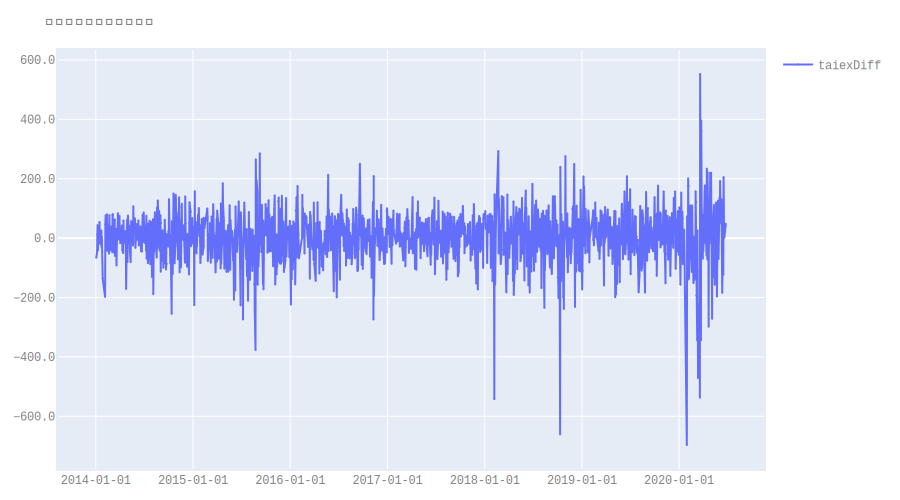

In [10]:
# taiexDiff.plot()
# plt.title('加權股價指數變動時序圖')
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=taiexDiff.index,
            y=taiexDiff,
            name = f"taiexDiff",
            mode='lines+markers',
            marker_size = 2
        ))
fig.update_layout(
    title=f"加權股價指數變動時序圖",
    showlegend=True,
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.1f'
    )
)
fig.show(renderer="svg", width=900, height=500)


## 計算ACF和PACF

In [11]:
acfs = stattools.acf(taiexDiff)
pacfs = stattools.pacf(taiexDiff)
print(f'ACF: \n{acfs[:13]}\n')
print(f'PACF: \n{pacfs[:13]}\n')

ACF: 
[ 1.          0.00643192  0.08046909  0.04028071 -0.0039491  -0.03556914
 -0.01134483  0.00605475  0.02397573 -0.02921481 -0.00629355  0.03107333
 -0.05024098]

PACF: 
[ 1.          0.00643599  0.08053273  0.03962063 -0.01088184 -0.04241774
 -0.01168055  0.01325029  0.02946727 -0.03098688 -0.01331206  0.03361744
 -0.04612864]



## 繪製taiexDiff的ACF和PACF圖
變動指數(taiexDiff)的ACF較大，而且快速衰減至0，可以推斷變動指數序列具定態性。

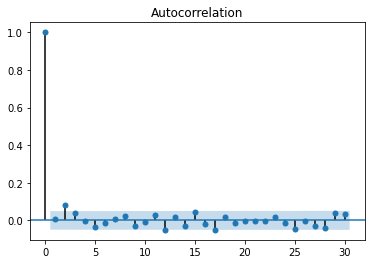

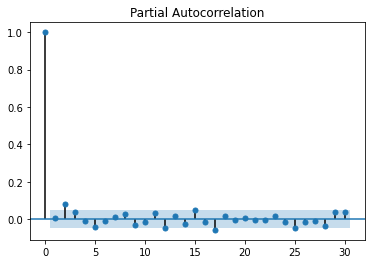

In [12]:
from statsmodels.graphics.tsaplots import *
_ = plot_acf(taiexDiff, use_vlines=True, lags=30)
_ = plot_pacf(taiexDiff, use_vlines=True, lags=30)

## 繪製close的ACF和PACF圖
收盤指數的ACF較大，而且衰減速度較慢，可以推斷收盤指數序列不具定態性。

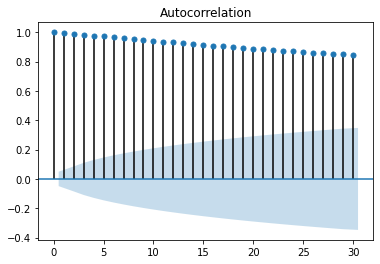

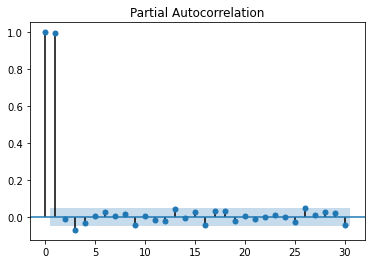

In [13]:
_ = plot_acf(close,use_vlines=True,lags=30)
_ = plot_pacf(close,use_vlines=True,lags=30)

## 單根檢定
雖然從ACF和PACF圖形來看是定態，但須進一步確認。使用Augmentted Dick-Fuller Test檢驗是否為定態

In [14]:
from arch.unitroot import ADF

print(f'ADF taiexDiff\n')
adf_taiexDiff=ADF(taiexDiff)
print(adf_taiexDiff.summary().as_text())

ADF taiexDiff

   Augmented Dickey-Fuller Results   
Test Statistic                -20.805
P-value                         0.000
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


由於$Test Statistic  =  -20.805 \leq Critical Values(5\%):-2.86 $  
拒絕單根

## White Noise Test
---
檢驗資料是否是隨機資料，如是隨機資料，則資料沒有可分析性。  
### 使用$Ljung-Box檢定$
$p-value: 0.0201 < 0.05$非白雜訊資料

In [15]:
LjungBox1=stattools.q_stat(stattools.acf(taiexDiff)[1:20],len(taiexRet))

msg = 'Reject Null Hypothesis.' if LjungBox1[1][-1]<0.05 else 'Cann Not Reject. White Noise '
print(f'p-value: {LjungBox1[1][-1]:.4f}\n{msg}')

p-value: 0.0201
Reject Null Hypothesis.


# Time Series

In [16]:
import statsmodels.api as sm
import itertools
import math

In [17]:
# y = taiexRet
y = taiexDiff
# y = taiexLogDiff
# y = close

## 使用AIC選取$AR(p), MA(q)$
選取最小的AIC當作最好的模型

### 觀察ACF和PACF圖
把$(p, q \in [0, 2]$配對組合) x $(P, Q\in [0, 2]$12個月季節性的搭配組合)<br/>
e.g (1, 0, 2) x (1, 0, 1, 12)<br/>
加入至備選模型中

In [18]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, [0], q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [0], q))]
# seasonal_pdq = [(0,0,0,0)]
print('Parameter combinations for Seasonal ARIMA...')
for i in pdq:
    for j in seasonal_pdq:
        print(f'SARIMAX: {i} x {j}')


Parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 0, 2, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
SARIMAX: (0, 0, 0) x (1, 0, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 2, 12)
SARIMAX: (0, 0, 0) x (2, 0, 0, 12)
SARIMAX: (0, 0, 0) x (2, 0, 1, 12)
SARIMAX: (0, 0, 0) x (2, 0, 2, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (0, 0, 1) x (1, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 2, 12)
SARIMAX: (0, 0, 1) x (2, 0, 0, 12)
SARIMAX: (0, 0, 1) x (2, 0, 1, 12)
SARIMAX: (0, 0, 1) x (2, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 1, 12)
SARIMAX: (0, 0, 2) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (1, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 0, 1, 12)
SARIMAX: (0, 0, 2) x (1, 0, 2, 12)
SARIMAX: (0, 0, 2) x (2, 0, 0, 12)
SARIMAX: (0, 0, 2) x (2, 0, 1, 12)
SARIMAX: (0, 0, 2) x (2, 0, 2, 12)
SARIMAX: (

## 搜尋備選模型中AIC最小的

In [19]:
aicMin = 99999999999

aicModel = ''
modelParam = None
modelparam_seasonal = None
bestResult = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic <= aicMin:
                aicMin = results.aic
                aicModel = f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}'
                modelParam = param
                modelparam_seasonal = param_seasonal
                bestResult = results
        except Exception as e:
            print(e)
            continue
print(f'Min of AIC = {aicMin}')
print(aicModel)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:18653.664285172246
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:18520.582544295605
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:18382.706149145077
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:18531.552957742664
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:18522.527495566123
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:18384.611942686584
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:18393.591420824683
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:18395.580068200674
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:18386.43518690472
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:18644.538816189277
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:18511.59172279679
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:18373.841415177565
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:18533.433376945908
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:18513.50051766541
ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:18375.751326292466
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:18395.519170241656
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:18397.47781848254
ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:18377.575849569

### 由AIC方式選取最佳模型為
### $ARIMA(2, 0, 2)\ \times\ ARIMA\_SEASONAL(0,0,2,12)$


## Summary
### $ar(-1), ar(-1), ma(-1), ma(-2), maS(-1)$的 p-value小於0.05，都為顯著。

In [20]:
# ARIMA(2, 0, 2)x(0, 0, 2, 12) - AIC:18352.94030023842
# ARIMA(0, 0, 2)x(0, 0, 2, 12) - BIC:18354.486782422333
results  = bestResult
print(results.summary())

SARIMAX Results                                      
Dep. Variable:                         ClosePrice   No. Observations:                 1584
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 12)   Log Likelihood               -9169.470
Date:                            Thu, 02 Jul 2020   AIC                          18352.940
Time:                                    13:42:21   BIC                          18390.394
Sample:                                         0   HQIC                         18366.867
                                           - 1584                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5301      0.132      4.003      0.000       0.271       0.790
ar.L2         -0.4355      0.123     -3.545      0.000      -0.676      

## 畫出殘差圖
> Normal Q-Q 幾乎呈一直線  
> ACF圖也快速衰減至0

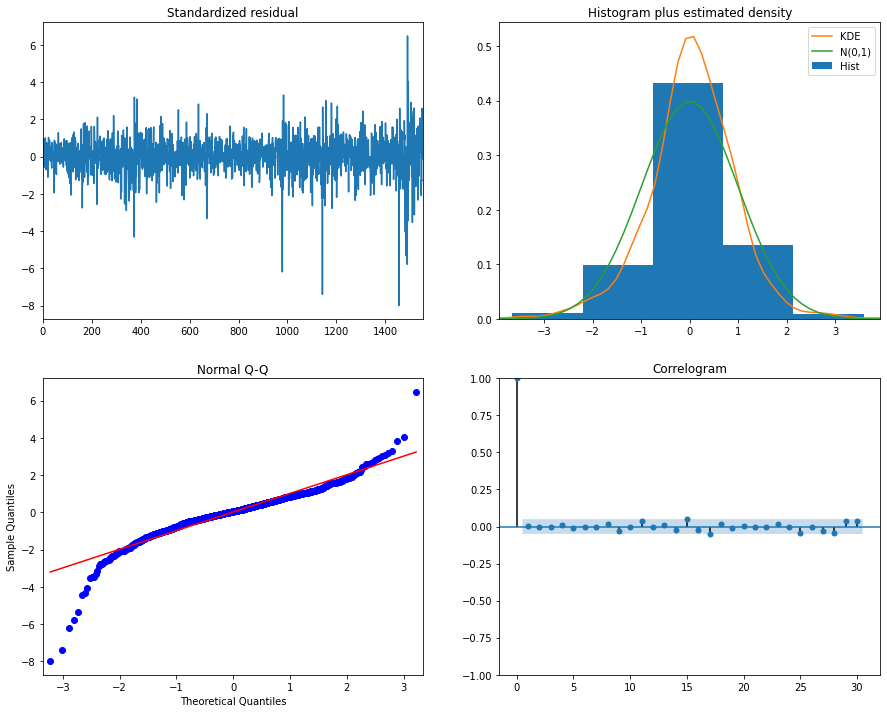

In [21]:
results.plot_diagnostics(figsize=(15, 12),lags= 30)
plt.show()

## White Noise Test
---
檢驗殘差是否為隨機資料，如是隨機資料，則模型充分解釋。  
### 使用$Ljung-Box檢定$
$p-value: 0.623 > 0.05$為白雜訊資料。

In [22]:
stdresid = results.resid / results.resid.std()
LjungBox=stattools.q_stat(stattools.acf(stdresid)[1:13],len(stdresid))
print(f'p-value: {LjungBox1[1][-1]:.4f}\n{msg}')

p-value: 0.0201
Reject Null Hypothesis.


### 觀察殘差絕對值

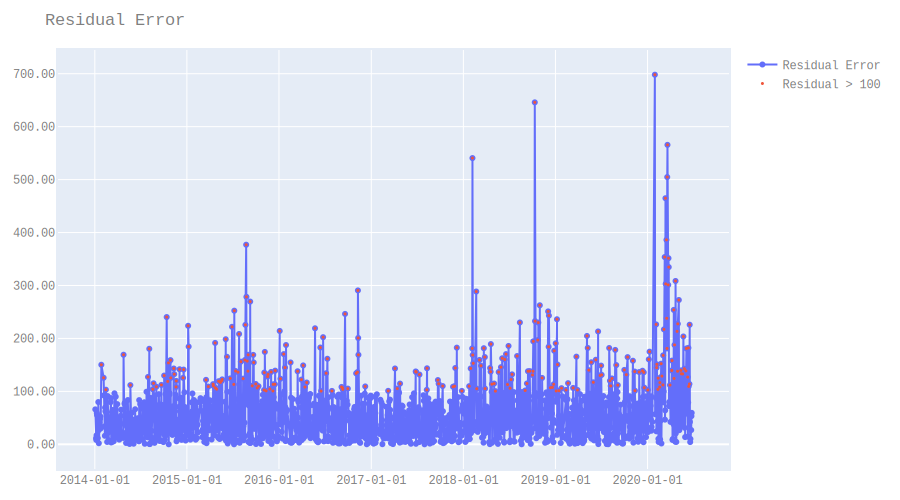

In [31]:
import psutil
# resid = [abs(i) for i in results.resid]
resid = results.resid.abs()
residMM = results.resid.apply(lambda x: abs(x) if abs(x)>100 else None).dropna()
# resid

fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=taiexDiff.index,
            y=resid,
            name = f"Residual Error",
            mode='lines+markers'
        ))
fig.add_trace(
    go.Scatter(
            x=residMM.index,
            y=residMM,
            name = f"Residual > 100",
            mode='markers',
            marker_size = 3
        ))
fig.update_layout(
    title=f"Residual Error",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)

# print(resid.describe())
fig.show(renderer="svg", width=900, height=500)


## 利用訓練的ARIMA觀察訓練結果

In [24]:
'''
If dynamic is False, then the in-sample lagged values are used for
prediction. 
If `dynamic` is True, then in-sample forecasts are used in place of
lagged dependent variables.
'''
pred = results.get_prediction(start=pandas.to_datetime('2020-03-10'), dynamic=False, full_results = True)
pred_ci = pred.conf_int(alpha = 0.5)
# print(pred.predicted_mean.describe())

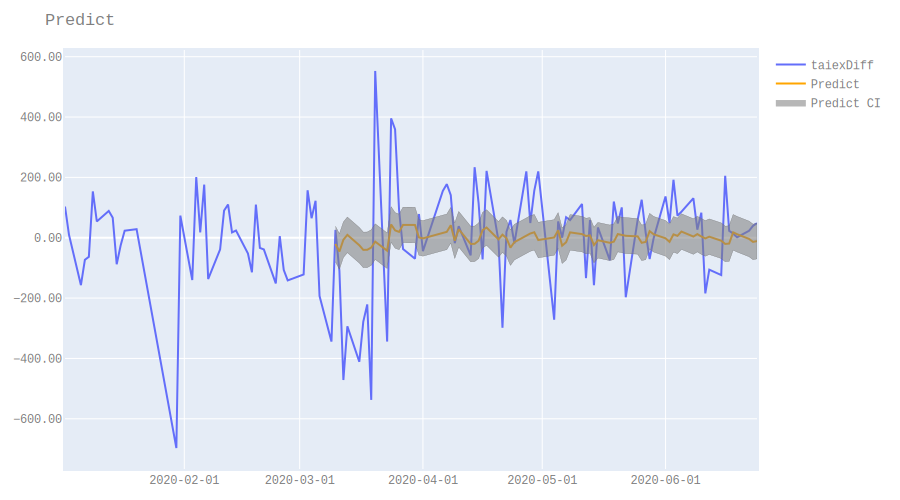

In [25]:
pred_std = pred.predicted_mean.std()
pred_mean = pred.predicted_mean.mean()
danger_pred = pred.predicted_mean.apply(lambda x: x if abs(x) > taiexDiff_MEAN else None).dropna()
fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=y['2020':].index,
            y=y['2020':],
            name = f"taiexDiff",
            mode='lines'
        ))
fig.add_trace(
    go.Scatter(
            x=danger_pred.index,
            y=danger_pred,
            name = f"Residual ",
            mode='markers',
            marker_size = 5
        ))
fig.add_trace(go.Scatter(
        # x=pred_ci.index,
        x=pred_ci.index,
        y=pred.predicted_mean,
        mode='lines',
        name="Predict",
        line_color='#FFA500',
        line=dict(width=2)
    ))
    
cofInterval = pandas.concat([pred_ci.iloc[:, 0], pred_ci.iloc[::-1, 1]])

fig.add_trace(go.Scatter(
        # x=pred_ci.index,
        x=cofInterval.index,
        y=cofInterval,
        fill='toself',
        hoveron='points',
        name="Predict CI",
        line_color='RGBA(105,105,105,1)',
        fillcolor = 'RGBA(128, 128, 128,0.56)',
        line=dict(width=0.3)
    ))
fig.update_layout(
    title=f"Predict",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)

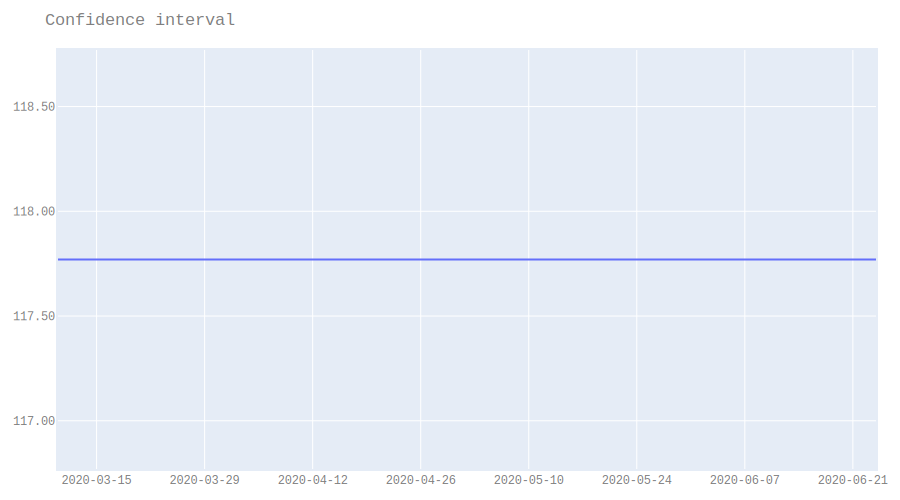

In [26]:
CI = (pred_ci.iloc[:, 0] - pred_ci.iloc[::, 1]).abs()

fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=CI.index,
            y=CI,
            name = f"CI",
            mode='lines'
        ))
fig.update_layout(
    title=f"Confidence interval",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)
# print(CI.describe())


In [27]:
# y_forecasted = pred.predicted_mean
# y_truth = y['2020-06-01':]

# # Compute the mean square error
# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

## 預測未來50天資料

In [28]:
date = f'2020-04-{5:02}'
y_forecasted = taiexDiff[:date]
param = (2, 0, 2)
param_seasonal = (0, 0, 2, 12)
mod = sm.tsa.statespace.SARIMAX(y_forecasted,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_forecasted = mod.fit()

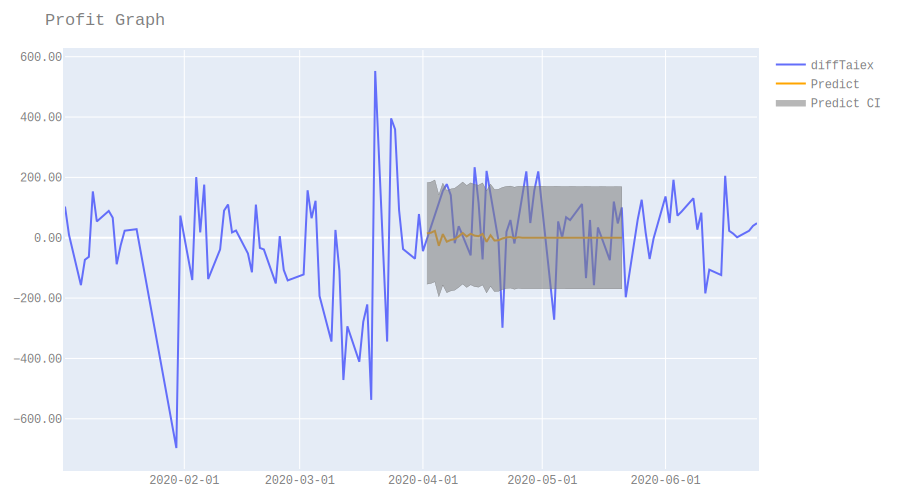

In [29]:

# Get forecast 50 steps ahead in future
steps = 50
pred_uc = results_forecasted.get_forecast(steps=steps)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=0.05)
forecastDate = [y_forecasted.index[-1] + datetime.timedelta(days = 1*(i+1)) for i in range(steps)]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=y['2020':].index,
            y=y['2020':],
            name = f"diffTaiex",
            mode='lines'
        ))
fig.add_trace(go.Scatter(
        # x=pred_ci.index,
        x=forecastDate,
        y=pred_uc.predicted_mean,
        mode='lines',
        name="Predict",
        line_color='#FFA500',
        line=dict(width=2)
    ))
    
cofInterval = pandas.concat([pred_ci.iloc[:, 0], pred_ci.iloc[::-1, 1]])
fig.add_trace(go.Scatter(
        x=forecastDate+forecastDate[::-1],
        y=cofInterval,
        fill='toself',
        mode="lines",
        hoveron='points',
        name="Predict CI",
        line_color='RGBA(105,105,105,1)',
        fillcolor = 'RGBA(128, 128, 128,0.56)',
        line=dict(width=0.3)
    ))
fig.update_layout(
    title=f"Profit Graph",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)

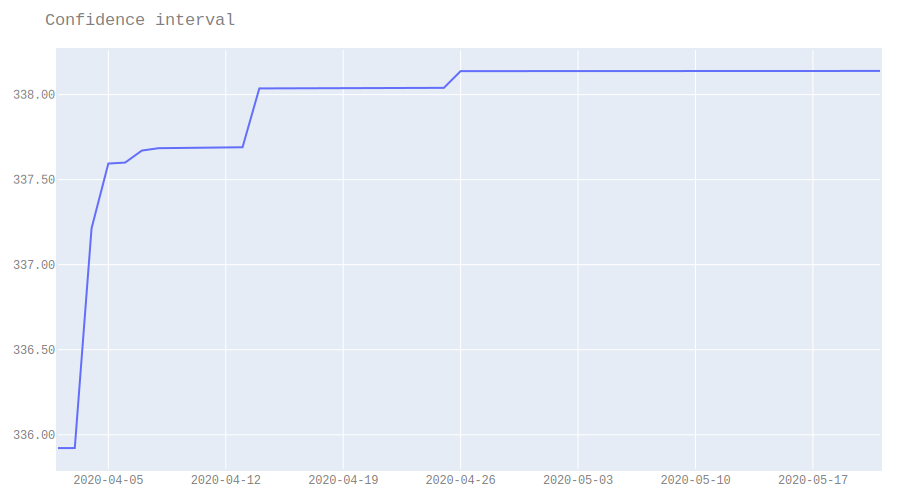

In [32]:
CI = (pred_ci.iloc[:, 0] - pred_ci.iloc[::, 1]).abs()

fig = go.Figure()

fig.add_trace(
    go.Scatter(
            x=forecastDate,
            y=CI,
            name = f"CI",
            mode='lines'
        ))
fig.update_layout(
    title=f"Confidence interval",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title",
    width=900,
    height=500,
    margin=dict(
        l=20,
        r=20,
        b=20,
        t=50,
        pad=2
    ),
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    ),
    xaxis=plotly.graph_objects.layout.XAxis(
        tickformat='%Y-%m-%d'
    ),
    yaxis=plotly.graph_objects.layout.YAxis(
        tickformat='.2f'
    )
)
fig.show(renderer="svg", width=900, height=500)